<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/sqr_2_order_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install casadi

In [4]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_trajectory_with_wind(result, k_value):
    # 1. Get results
    x_traj = result["x"]
    h_traj = result["h"]

    # 2. Grids
    x_grid = np.linspace(0, 9000, 100)
    h_grid = np.linspace(0, 1100, 60)
    X, H = np.meshgrid(x_grid, h_grid)

    # 3. Wind Model
    a, b, c = 200, 4500, 2000
    h_star = 1000
    eps = 1e-6

    def Wx(x):
        return np.where(
            x <= a, -k_value,
            np.where(x <= b, -k_value + 2 * k_value * (x - a) / (b - a + eps), k_value)
        )

    def Wh(x, h):
        out = np.zeros_like(x)
        mask1 = (x >= a) & (x <= c)
        mask2 = (x >= c) & (x <= b)
        out[mask1] = -k_value * h[mask1] / h_star * (x[mask1] - a) / (c - a + eps)
        out[mask2] = -k_value * h[mask2] / h_star * (b - x[mask2]) / (b - c + eps)
        return out

    # 4. Compute wind field
    Wx_vals = Wx(X)
    Wh_vals = Wh(X, H)

    # 5. Plot
    plt.figure(figsize=(10, 6))
    plt.streamplot(x_grid, h_grid, Wx_vals, Wh_vals, density=1.2, linewidth=0.7, color="lightblue")
    plt.plot(x_traj, h_traj, 'k', linewidth=2, label="Trajectory")
    plt.xlabel("horizontal distance [ft]")
    plt.ylabel("altitude [ft]")
    plt.title(f"Trajectory with wind field (k = {k_value})")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.gca().set_aspect('auto')
    plt.show()

In [10]:
def solve_ocp(k_value):
    tf = 40
    N = 40
    dt = tf / N

    # Constants
    hR = 1000
    m = 4662
    g = 32.172
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    delta = 0.03491
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    a, b, c = 200, 4500, 2000
    h_star = 1000
    eps = 1e-6

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # Define symbolic vars for wind gradient
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")

    def wind_x(x_):
        return ca.if_else(x_ <= a, -k_value,
               ca.if_else(x_ <= b, -k_value + 2 * k_value * (x_ - a) / (b - a + eps), k_value))

    def wind_h(x_, h_):
        return ca.if_else(x_ < a, 0.0,
               ca.if_else(x_ <= c, -k_value * h_ / h_star * (x_ - a) / (c - a + eps),
                 ca.if_else(x_ <= b, -k_value * h_ / h_star * (b - x_) / (b - c + eps), 0.0)))

    # Define symbolic expressions
    Wx_expr = wind_x(x_sym)
    Wh_expr = wind_h(x_sym, h_sym)

    # Compute symbolic gradients
    dWx_dx_fun = ca.Function("dWx_dx_fun", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx_fun", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh_fun", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])


    # Dynamics
    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.1 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        Wx = wind_x(x_)
        Wh = wind_h(x_, h_)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        # Evaluate wind derivatives at current state
        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = (
            T / m * ca.cos(alpha_ + delta)
            - D / m
            - g * ca.sin(gamma_)
            - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        )

        gamma_dot = (
            T / (m * V_safe) * ca.sin(alpha_ + delta)
            + L / (m * V_safe)
            - g / V_safe * ca.cos(gamma_)
            + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        )

        alpha_dot = u_
        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Create integrator
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    ode_rhs = aircraft_ode(X_sym, u_sym)
    ode = {"x": X_sym, "p": u_sym, "ode": ode_rhs}
    # intg = ca.integrator("intg", "cvodes", ode, {"t0": 0, "tf": dt})
    intg = ca.integrator("intg", "rk", ode, {"tf": dt})

    # Initial + terminal conditions
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    # Collocation constraints
    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # Objective
    hR = 1000
    # J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i])**3 for i in range(N+1)]))
    J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i]) for i in range(N+1)]))
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, ca.linspace(600, 1000, N+1))
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    # Solver
    opti.solver('ipopt', {
        'ipopt': {
            'max_iter': 1000,
            'tol': 1e-6,
            'print_level': 0,
            'linear_solver': 'mumps',
            'hessian_approximation': 'limited-memory'
        }
    })

    sol = opti.solve()
    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "J": sol.value(J),
    }


In [58]:
result30 = solve_ocp(k_value=30)

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      206
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80


Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:   1.1471354318183017e+05    9.1770834545464139e+05
Dual infeasibility......:   2.2479705515299556e-05    1.7983764412239645e-04
Constraint violation....:   5.5479176808148623e-11    5.5479176808148623e-11
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

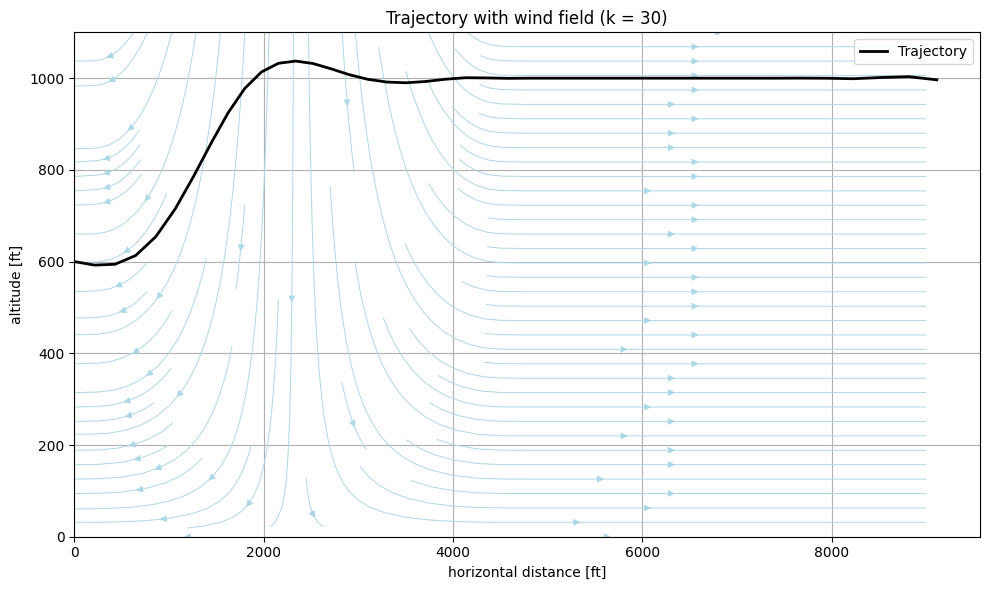

In [59]:
plot_trajectory_with_wind(result30, k_value=30)

In [60]:
result50 = solve_ocp(k_value=50)

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      206
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80


Number of Iterations....: 90

                                   (scaled)                 (unscaled)
Objective...............:   2.6235863416009524e+05    2.0988690732807619e+06
Dual infeasibility......:   2.2890484677162704e-04    1.8312387741730163e-03
Constraint violation....:   4.7293724492192268e-11    4.7293724492192268e-11
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

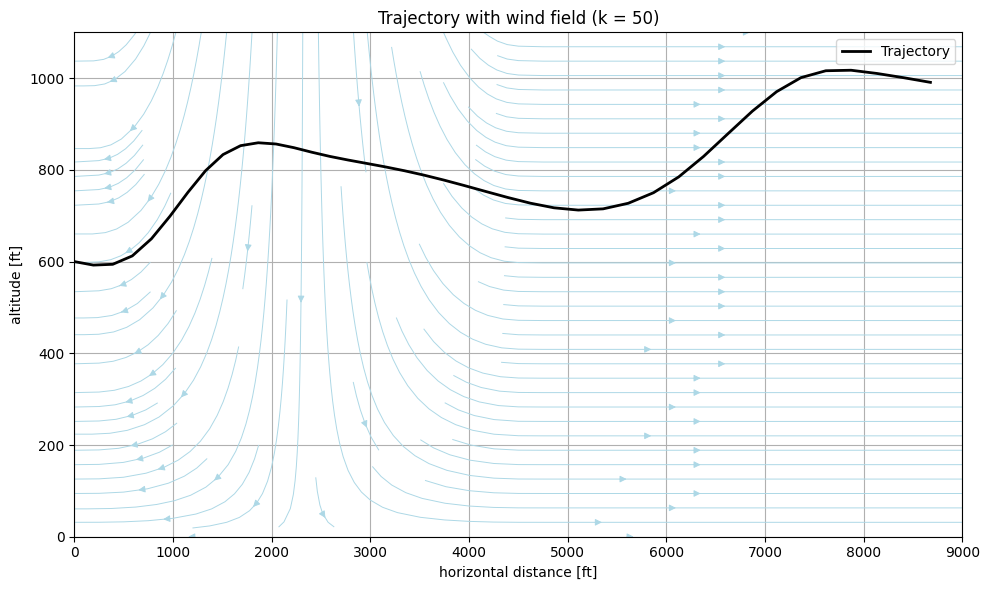

In [61]:
plot_trajectory_with_wind(result50, k_value=50)

In [6]:
!pip install chaospy

In [7]:
import chaospy as cp

In [11]:
def pce_uncertainty_analysis(k0=50, rel_sigma=0.25, order=3):
    # Define standard normal ξ ~ N(0,1)
    dist = cp.Normal(0, 1)
    # basis = cp.stieltjes(order, dist)
    basis = cp.generate_expansion(order, dist)
    nodes, weights = cp.generate_quadrature(order, dist, rule="gaussian")

    Js = []
    for i, xi in enumerate(nodes[0]):
        k_sample = k0 * (1 + rel_sigma * xi)
        print(f"Evaluating at k = {k_sample:.2f}")
        result = solve_ocp(k_sample)
        Js.append(result["J"])

    # Fit PCE surrogate
    coeffs = cp.fit_quadrature(basis, nodes, weights, Js)

    # Monte Carlo sampling
    samples = dist.sample(1000)
    J_samples = coeffs(*samples)

    J_samples = np.array(J_samples)
    J_samples = J_samples[np.isfinite(J_samples)]

    print(f"Mean J ≈ {np.mean(J_samples):.2f}")
    print(f"Std J  ≈ {np.std(J_samples):.2f}")

    plt.hist(J_samples, bins=30)
    plt.title("Histogram of J(k) (PCE)")
    plt.xlabel("Cost J")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

In [12]:
pce_uncertainty_analysis()

Evaluating at k = 20.82


CasADi - 2025-05-20 15:19:43 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:692]



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 236.00us ( 15.73us) 228.22us ( 15.21us)        15
       nlp_g  | 453.01ms ( 30.20ms) 454.40ms ( 30.29ms)        15
  nlp_grad_f  | 411.00us ( 25.69us) 355.43us ( 22.21us)        16
   nlp_jac_g  |   3.53 s (220.84ms)   3.51 s (219.08ms)        16
       total  |   4.11 s (  4.11 s)   4.08 s (  4.08 s)         1


CasADi - 2025-05-20 15:19:48 WARNING("IpoptUserClass::eval_jac_g failed:.../casadi/core/oracle_function.cpp:367: Error in solver:nlp_jac_g:KeyboardInterrupt") [.../casadi/interfaces/ipopt/ipopt_nlp.cpp:159]


RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1334: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Invalid_Number_Detected'

In [13]:
def compare_mc_vs_pce(k0=50, rel_sigma=0.25, order=3, quantity="J", nsamples=10):
    import time

    dist = cp.Normal(0, 1)
    basis = cp.generate_expansion(order, dist)
    nodes, weights = cp.generate_quadrature(order+1, dist, rule="gaussian")

    ### Step 1: Run quadrature samples for PCE
    values = []
    ks_quad = []
    for i, xi in enumerate(nodes[0]):
        k_sample = k0 * (1 + rel_sigma * xi)
        ks_quad.append(k_sample)
        print(f"[PCE] Evaluating at k = {k_sample:.2f}")
        try:
            result = solve_ocp(k_sample)
            if quantity == "J":
                values.append(result["J"])
            elif quantity == "h":
                values.append(result["h"][-1])
            else:
                raise ValueError("Unknown quantity")
        except:
            print(f"[PCE] Failed at k = {k_sample:.2f}")
            values.append(np.nan)

    # Drop NaNs for PCE fit
    nodes_valid = [x for x, v in zip(nodes[0], values) if np.isfinite(v)]
    values_valid = [v for v in values if np.isfinite(v)]
    basis_valid = cp.generate_expansion(order, cp.Normal(0, 1))
    surrogate = cp.fit_regression(basis_valid, np.array(nodes_valid), values_valid)

    ### Step 2: Run MC directly
    xi_samples = dist.sample(nsamples)
    xi_samples = xi_samples.flatten()  # shape = (1000,)
    k_samples = k0 * (1 + rel_sigma * xi_samples)
    mc_results = []
    t0 = time.time()
    for k in k_samples:
        try:
            result = solve_ocp(k)
            if quantity == "J":
                mc_results.append(result["J"])
            elif quantity == "h":
                mc_results.append(result["h"][-1])
        except:
            mc_results.append(np.nan)
    t1 = time.time()
    print(f"Monte Carlo time: {t1 - t0:.1f} s")

    ### Step 3: Evaluate surrogate
    t2 = time.time()
    pce_results = surrogate(*xi_samples)
    t3 = time.time()
    print(f"PCE surrogate time: {t3 - t2:.2f} s")

    ### Step 4: Compare
    mc_results = np.array(mc_results)
    pce_results = np.array(pce_results)
    mc_results = mc_results[np.isfinite(mc_results)]
    pce_results = pce_results[np.isfinite(pce_results)]

    print("\nComparison:")
    print(f"MC  mean = {np.mean(mc_results):.2f}, std = {np.std(mc_results):.2f}")
    print(f"PCE mean = {np.mean(pce_results):.2f}, std = {np.std(pce_results):.2f}")

    # Histogram
    plt.hist(mc_results, bins=30, alpha=0.5, label="Monte Carlo")
    plt.hist(pce_results, bins=30, alpha=0.5, label="PCE surrogate")
    plt.title(f"Distribution of {quantity}(k)")
    plt.xlabel(f"{quantity}")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()


[PCE] Evaluating at k = 14.29
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 991.00us ( 15.25us) 975.56us ( 15.01us)        65
       nlp_g  |   2.10 s ( 32.32ms)   2.66 s ( 40.97ms)        65
  nlp_grad_f  |   1.33ms ( 24.70us)   1.33ms ( 24.71us)        54
   nlp_jac_g  |  13.03 s (241.38ms)  15.65 s (289.85ms)        54
       total  |  15.69 s ( 15.69 s)  19.00 s ( 19.00 s)         1
[PCE] Evaluating at k = 33.05
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.21ms ( 15.32us)   1.19ms ( 15.10us)        79
       nlp_g  |   2.51 s ( 31.71ms)   2.52 s ( 31.84ms)        79
  nlp_grad_f  |   2.07ms ( 25.93us)   2.10ms ( 26.28us)        80
   nlp_jac_g  |  18.88 s (235.95ms)  19.05 s (238.18ms)        80
       total  |  22.16 s ( 22.16 s)  22.36 s ( 22.36 s)         1
[PCE] Evaluating at k = 50.00
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.44ms ( 15.21us)   1.42ms ( 14.97

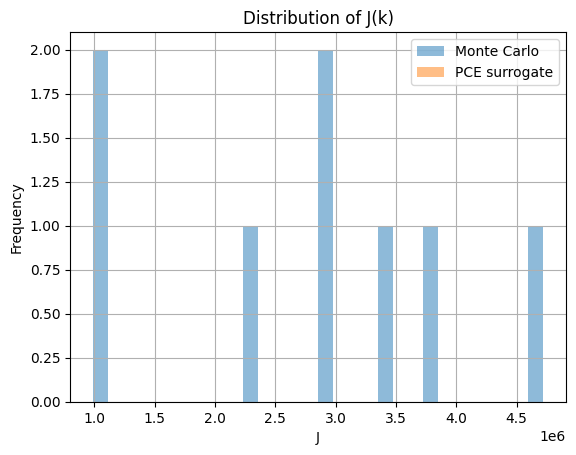

In [14]:
compare_mc_vs_pce(quantity="J")